# A computational introduction to stochastic differential equations.

Lecture 4.

https://github.com/spdes/computational-sde-intro-lecture.

Parameter estimation using maximum likelihood.

In [17]:
import jax
import jaxopt
import jax.numpy as jnp
import jax.scipy.stats
import matplotlib.pyplot as plt
from jax.config import config

config.update("jax_enable_x64", True)

In [18]:
def drift(x, theta):
    return theta * jnp.sin(x)

def dispersion(_):
    return jnp.array(1.)

def cond_mean_variance_euler_maruyama(x, dt, theta):
    return x + drift(x, theta) * dt, dispersion(x) ** 2 * dt

def disc_normal(m_and_cov, x0, dt, xis, theta):
    def scan_body(carry, elem):
        x = carry
        xi = elem

        m, variance = m_and_cov(x, dt, theta)
        x = m + jnp.sqrt(jnp.squeeze(variance)) * xi
        return x, x

    _, sample = jax.lax.scan(scan_body, x0, xis)
    return sample

In [19]:
dt = 1e-3
T = 100000
ts = jnp.linspace(dt, dt * T, T)

x0 = 0.
key = jax.random.PRNGKey(666)

true_theta = 2.

xis = jax.random.normal(key, (T, ))
xs = disc_normal(cond_mean_variance_euler_maruyama, x0, dt, xis, true_theta)

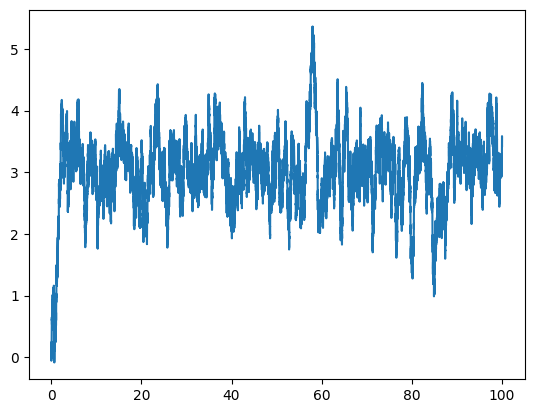

In [20]:
_ = plt.plot(ts, xs)

In [21]:
def objective_func(theta):
    cond_means, cond_variances = jax.vmap(cond_mean_variance_euler_maruyama, in_axes=[0, None, None])(xs[:-1], dt, theta)
    log_pdfs = -jnp.sum(jax.scipy.stats.norm.logpdf(xs[1:], cond_means, cond_variances))
    return log_pdfs

In [22]:
init_theta = jnp.array(0.)
opt_solver = jaxopt.ScipyMinimize(method='L-BFGS-B', fun=objective_func)
opt_vals, opt_state = opt_solver.run(init_theta)

In [23]:
opt_vals

DeviceArray(2.17597326, dtype=float64)